In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pywt
from typing import Tuple, Optional

In [2]:
# Constants
RANGE_BINS = 180
CYCLES = 17
BEAMS = 5
NFFT = 256
INCI = 5

datawd_real min/max: -0.6449391114726534 2.511225211548076
datawd_imag min/max: -0.5275196591525189 3.6253650274105045
mu: 2.0 tau: 0.4 pseudos: 0.2169233760639239 sigma_d2: 0.08792364110997464
Level 4 - d_mag min/max: 0.000379482630932373 0.7514273072282864
Level 4 - delta_star min/max: 0.0005234255476121255 0.14898351759035436
Level 3 - d_mag min/max: 1.9415573010698148 3.694769422134482
Level 3 - delta_star min/max: 0.1999999866612177 0.19999999949819625


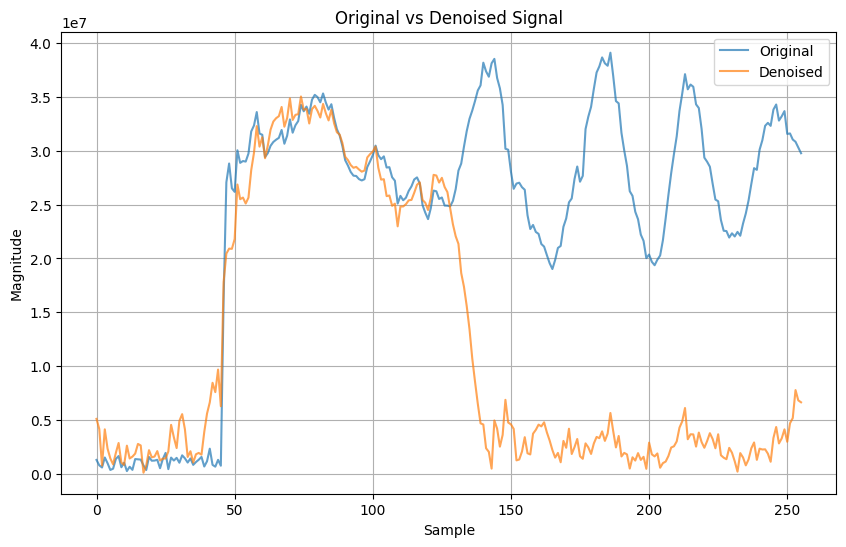

In [3]:
def load_iq_data(file_path: str) -> np.ndarray:
    """Load IQ data from a NetCDF file into a 5D array."""
    try:
        dataset = nc.Dataset(file_path, 'r')
        iq_data = np.zeros((CYCLES, BEAMS, INCI, RANGE_BINS, NFFT), dtype=complex)
        for c in range(CYCLES):
            for b in range(BEAMS):
                for i in range(INCI):
                    raw_i = dataset.variables[f'RawI.R.1.C.{c+1}.B.{b+1}'][i]
                    raw_q = dataset.variables[f'RawQ.R.1.C.{c+1}.B.{b+1}'][i]
                    iq_data[c, b, i] = raw_i + 1j * raw_q
        return iq_data
    except FileNotFoundError:
        raise FileNotFoundError(f"NetCDF file not found: {file_path}")
    except KeyError as e:
        raise KeyError(f"Missing expected variable in NetCDF file: {e}")

def mst_abs(
    signal: np.ndarray,
    wavelet: str = 'sym8',
    coarsest: int = 3,
    finestlev: int = 4,
    debug: bool = False
) -> np.ndarray:
    """
    Apply Adaptive-Bayesian Shrinkage to a complex signal using wavelet transforms.

    Args:
        signal: Complex input signal segment.
        wavelet: Wavelet type (default: 'sym8').
        coarsest: Coarsest decomposition level (default: 3).
        finestlev: Finest decomposition level (default: 4).
        debug: Enable debug printing (default: False).

    Returns:
        Denoised complex signal.
    """
    # Validate input
    if not np.iscomplexobj(signal):
        raise ValueError("Input signal must be complex.")

    # Separate real and imaginary parts
    real_part = signal.real
    imag_part = signal.imag

    # Forward Wavelet Transform
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)

    if debug:
        print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
        print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())

    # Compute prior parameters
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)
    mu = min(1 / pseudos**2 if pseudos != 0 else 1e-1, 2.0)
    sigma_d2 = np.var(np.abs(signal))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.4)

    if debug:
        print("mu:", mu, "tau:", tau, "pseudos:", pseudos, "sigma_d2:", sigma_d2)

    # Iterative shrinkage
    for i in range(finestlev, coarsest-1, -1):
        epsilon = min(1 - (1 / (i - coarsest + 1)), 0.3)
        slice_start, slice_end = 2**i, (2**(i+1) if i < finestlev else len(datawd_real))
        d_real = datawd_real[slice_start:slice_end]
        d_imag = datawd_imag[slice_start:slice_end]
        if len(d_real) == 0:
            continue

        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)
        m_star = epsilon * de + (1 - epsilon) * m

        # Vectorized shrinkage calculation
        num = tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))
        denom = (tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10
        delta_mag = np.clip(num / denom / mu, 0, 0.2)
        delta_star = np.clip(((1 - epsilon) * m * delta_mag) / (m_star + 1e-10), 0, 0.2)

        direction = d_real + 1j * d_imag
        direction_normalized = direction / (np.abs(direction) + 1e-10)
        datawd_real[slice_start:slice_end] = delta_star * direction_normalized.real
        datawd_imag[slice_start:slice_end] = delta_star * direction_normalized.imag

        if debug:
            print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
            print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())

    # Inverse Wavelet Transform
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    ysig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    ysig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    return (ysig_real + 1j * ysig_imag)[:len(signal)]

def main():
    """Main function to test the denoising process."""
    data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
    iq_data = load_iq_data(data_path)
    test_segment = iq_data[0, 0, 0, 0, :]  # First cycle, beam, integration, range bin
    max_magnitude = np.abs(test_segment).max()
    test_segment_normalized = test_segment / (max_magnitude + 1e-10)

    ysig_scaled = mst_abs(test_segment_normalized, debug=True) * max_magnitude

    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(test_segment), label='Original', alpha=0.7)
    plt.plot(np.abs(ysig_scaled), label='Denoised', alpha=0.7)
    plt.legend()
    plt.title('Original vs Denoised Signal')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

datawd_real min/max: -0.6449391114726534 2.511225211548076
datawd_imag min/max: -0.5275196591525189 3.6253650274105045
mu: 5.0 tau: 0.3 pseudos: 0.2169233760639239 sigma_d2: 0.08792364110997464
Level 4 - d_mag min/max: 0.000379482630932373 0.7514273072282864
Level 4 - delta_star min/max: 0.0023705782042132096 0.34551066363958904
Level 3 - d_mag min/max: 1.9415573010698148 3.694769422134482
Level 3 - delta_star min/max: 0.49999924320115036 0.4999999954068711


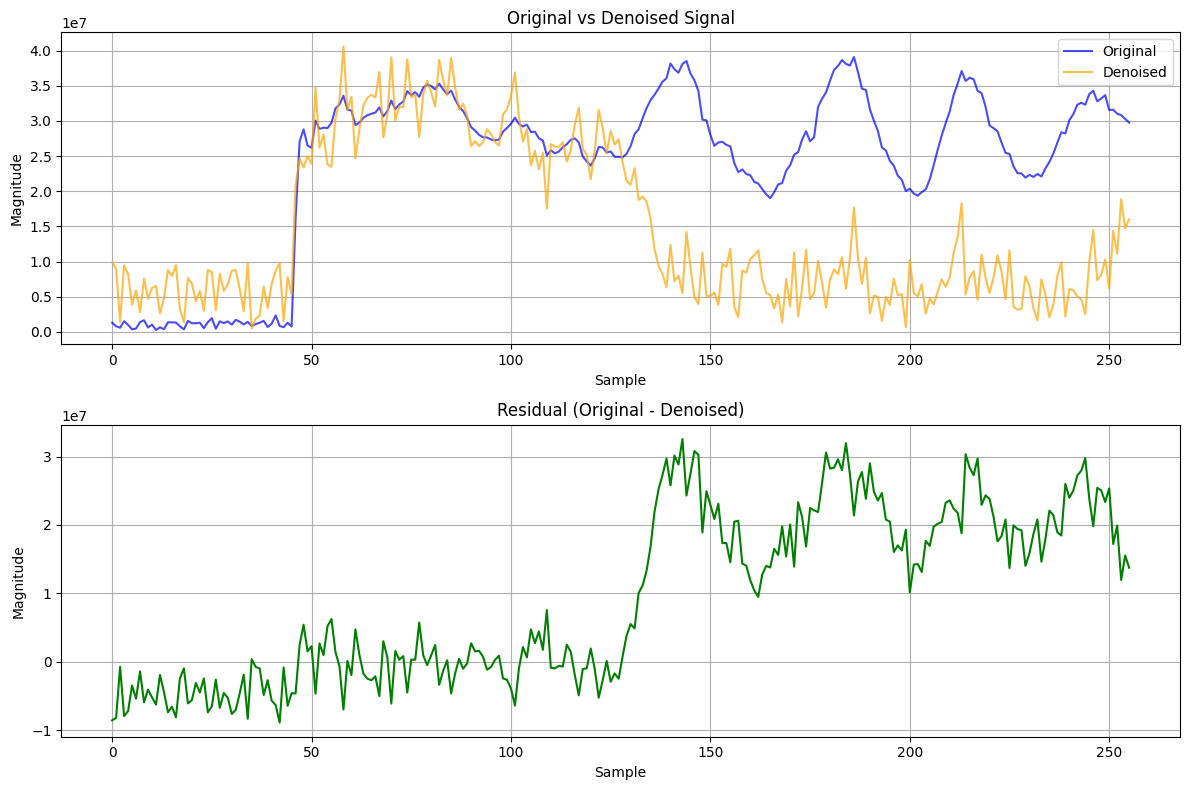

In [4]:
def load_iq_data(file_path: str) -> np.ndarray:
    """Load IQ data from a NetCDF file into a 5D array."""
    try:
        dataset = nc.Dataset(file_path, 'r')
        iq_data = np.zeros((CYCLES, BEAMS, INCI, RANGE_BINS, NFFT), dtype=complex)
        for c in range(CYCLES):
            for b in range(BEAMS):
                for i in range(INCI):
                    raw_i = dataset.variables[f'RawI.R.1.C.{c+1}.B.{b+1}'][i]
                    raw_q = dataset.variables[f'RawQ.R.1.C.{c+1}.B.{b+1}'][i]
                    iq_data[c, b, i] = raw_i + 1j * raw_q
        return iq_data
    except FileNotFoundError:
        raise FileNotFoundError(f"NetCDF file not found: {file_path}")
    except KeyError as e:
        raise KeyError(f"Missing expected variable in NetCDF file: {e}")

def mst_abs(
    signal: np.ndarray,
    wavelet: str = 'sym8',
    coarsest: int = 3,
    finestlev: int = 4,
    debug: bool = False
) -> np.ndarray:
    """
    Apply Adaptive-Bayesian Shrinkage to a complex signal using wavelet transforms.

    Args:
        signal: Complex input signal segment.
        wavelet: Wavelet type (default: 'sym8').
        coarsest: Coarsest decomposition level (default: 3).
        finestlev: Finest decomposition level (default: 4).
        debug: Enable debug printing (default: False).

    Returns:
        Denoised complex signal.
    """
    # Validate input
    if not np.iscomplexobj(signal):
        raise ValueError("Input signal must be complex.")

    # Separate real and imaginary parts
    real_part = signal.real
    imag_part = signal.imag

    # Forward Wavelet Transform
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)

    if debug:
        print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
        print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())

    # Compute prior parameters
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)
    # mu = min(1 / pseudos**2 if pseudos != 0 else 1e-1, 2.0)
    mu = min(1 / pseudos**2 if pseudos != 0 else 1e-1, 5.0)  # Increase max mu
    sigma_d2 = np.var(np.abs(signal))
    # tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.4)
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.3)  # Decrease min tau

    if debug:
        print("mu:", mu, "tau:", tau, "pseudos:", pseudos, "sigma_d2:", sigma_d2)

    # Iterative shrinkage
    for i in range(finestlev, coarsest-1, -1):
        # epsilon = min(1 - (1 / (i - coarsest + 1)), 0.3)
        epsilon = min(1 - (1 / (i - coarsest + 1)**0.8), 0.5)  # Softer decay, higher max
        slice_start, slice_end = 2**i, (2**(i+1) if i < finestlev else len(datawd_real))
        d_real = datawd_real[slice_start:slice_end]
        d_imag = datawd_imag[slice_start:slice_end]
        if len(d_real) == 0:
            continue

        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)
        m_star = epsilon * de + (1 - epsilon) * m

        # Vectorized shrinkage calculation
        num = tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))
        denom = (tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10
        # delta_mag = np.clip(num / denom / mu, 0, 0.2)
        delta_mag = np.clip(num / denom / mu, 0, 0.5)  # Increase from 0.2 to 0.5
        # delta_star = np.clip(((1 - epsilon) * m * delta_mag) / (m_star + 1e-10), 0, 0.2)
        delta_star = np.clip(((1 - epsilon) * m * delta_mag) / (m_star + 1e-10), 0, 0.5)  # Increase from 0.2 to 0.5

        direction = d_real + 1j * d_imag
        direction_normalized = direction / (np.abs(direction) + 1e-10)
        datawd_real[slice_start:slice_end] = delta_star * direction_normalized.real
        datawd_imag[slice_start:slice_end] = delta_star * direction_normalized.imag

        if debug:
            print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
            print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())

    # Inverse Wavelet Transform
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    ysig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    ysig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    return (ysig_real + 1j * ysig_imag)[:len(signal)]

def main():
    """Main function to test the denoising process."""
    data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
    iq_data = load_iq_data(data_path)
    test_segment = iq_data[0, 0, 0, 0, :]  # First cycle, beam, integration, range bin
    max_magnitude = np.abs(test_segment).max()
    test_segment_normalized = test_segment / (max_magnitude + 1e-10)

    ysig_scaled = mst_abs(test_segment_normalized, debug=True) * max_magnitude

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(np.abs(test_segment), label='Original', alpha=0.7, color='blue')
    plt.plot(np.abs(ysig_scaled), label='Denoised', alpha=0.7, color='orange')
    plt.legend()
    plt.title('Original vs Denoised Signal')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(np.abs(test_segment) - np.abs(ysig_scaled), label='Residual', color='green')
    plt.title('Residual (Original - Denoised)')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()